In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from tensorflow import keras
from keras.saving import register_keras_serializable
import os


from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os





num_classes=10

import tensorflow as tf
from tensorflow.keras import layers, models, Input



def GhostModule(out_channels, ratio=2, kernel_size=1, stride=1, use_relu=True):
    def layer(x):
        init_channels = int(out_channels / ratio)
        cheap_channels = out_channels - init_channels

        # Primary convolution
        x1 = layers.Conv2D(init_channels, kernel_size, strides=stride, padding='same', use_bias=False)(x)
        x1 = layers.BatchNormalization()(x1)
        if use_relu:
            x1 = layers.ReLU()(x1)

        # Cheap operations
        x2 = layers.DepthwiseConv2D(kernel_size=3, strides=1, padding='same', use_bias=False)(x1)
        x2 = layers.BatchNormalization()(x2)
        if use_relu:
            x2 = layers.ReLU()(x2)

        # Concatenate and trim
        out = layers.Concatenate()([x1, x2])
        return out[:, :, :, :out_channels]
    return layer

def SEBlock(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    x = layers.GlobalAveragePooling2D()(input_tensor)
    x = layers.Dense(channels // reduction, activation='relu')(x)
    x = layers.Dense(channels, activation='sigmoid')(x)
    x = layers.Reshape((1, 1, channels))(x)
    return layers.multiply([input_tensor, x])

def GhostBottleneck(x, out_channels, stride, use_se=False):
    in_channels = x.shape[-1]

    # 1st GhostModule
    residual = x
    x = GhostModule(out_channels)(x)

    # Optional SE
    if use_se:
        x = SEBlock(x)

    # Downsampling if needed
    if stride > 1:
        x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)

    # Match shortcut
    if stride > 1 or in_channels != out_channels:
        residual = layers.Conv2D(out_channels, kernel_size=1, strides=stride, padding='same', use_bias=False)(residual)
        residual = layers.BatchNormalization()(residual)

    x = layers.Add()([x, residual])
    return x


def GhostNetV2(input_shape=(32, 32, 3), num_classes=4):
    inputs = tf.keras.Input(shape=input_shape)

    x = GhostModule(32, stride=1)(inputs)
    x = GhostBottleneck(x, 64, stride=1)
    x = GhostBottleneck(x, 512, stride=1, use_se=True)

    x1 = GhostModule(1024,kernel_size=5)(x)
    x2 = GhostModule(1024,kernel_size=3)(x)
    x=  layers.Concatenate()([x1, x2])
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)
model=GhostNetV2(input_shape=(32, 32, 3), num_classes=10)
model.summary()


2025-07-16 20:59:09.491930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752699549.678512      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752699549.734462      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1752699564.345903      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752699564.346676      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │         48 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 32, 32,    │        144 │ re_lu[0][0]       │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ re_lu[0][0],      │
│ (Concatenate)       │ 32)               │            │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 32, 32,    │          0 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      1,024 │ get_item[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 32, 32,    │        288 │ re_lu_2[0][0]     │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ re_lu_2[0][0],    │
│ (Concatenate)       │ 64)               │            │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      2,048 │ get_item[0][0]  

 Total params: 9,043,850 (34.50 MB)

 Trainable params: 9,037,386 (34.47 MB)

 Non-trainable params: 6,464 (25.25 KB)

In [2]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
# Normalize the data. Before we need to connvert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [4]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 100
data_augmentation = False

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

# Define optimizer and compile the model
optimizer = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# Directory to save models
checkpoint_path = "models/epoch_{epoch:02d}_valacc_{val_accuracy:.4f}.keras"

# Callback to save model at every epoch and track the best one
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,       # Only keep the best one (based on val_accuracy)
    save_weights_only=False,
    mode='max'
)




reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)


history = None 

datagen = ImageDataGenerator(
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_callback,reduce_lr],
)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1752699578.259746      60 service.cc:148] XLA service 0x7a653801cfc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752699578.268367      60 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752699578.268388      60 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752699579.006927      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1752699600.409439      60 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing war

   1/1563 ━━━━━━━━━━━━━━━━━━━━ 14:22:26 33s/step - accuracy: 0.2188 - loss: 2.3952

I0000 00:00:1752699604.280048      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 176/1563 ━━━━━━━━━━━━━━━━━━━━ 2:52 125ms/step - accuracy: 0.2682 - loss: 2.0595

E0000 00:00:1752699639.925870      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752699640.087759      61 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.3589 - loss: 1.7694
Epoch 1: val_accuracy improved from -inf to 0.50140, saving model to models/epoch_01_valacc_0.5014.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 306s 175ms/step - accuracy: 0.3590 - loss: 1.7693 - val_accuracy: 0.5014 - val_loss: 1.4015 - learning_rate: 1.0000e-04
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.4868 - loss: 1.4367
Epoch 2: val_accuracy improved from 0.50140 to 0.54310, saving model to models/epoch_02_valacc_0.5431.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 262s 168ms/step - accuracy: 0.4869 - loss: 1.4367 - val_accuracy: 0.5431 - val_loss: 1.2853 - learning_rate: 1.0000e-04
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5289 - loss: 1.3158
Epoch 3: val_accuracy improved from 0.54310 to 0.57470, saving model to models/epoch_03_valacc_0.5747.keras
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 262s 167ms/step - accuracy: 0.5289 - loss: 1.3158 - val_accuracy: 0.5747 - val_loss: 

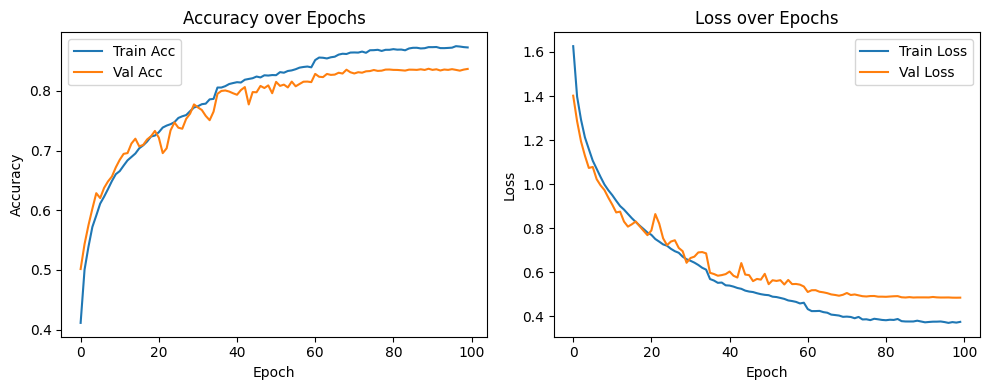

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Use full history if there was a second training phase
if 'history2' in locals():
    # Merge the two histories
    for key in history.history:
        history.history[key].extend(history2.history[key])

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
